In [20]:
import re
import random
import pandas as pd
import hashlib

In [21]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate', 'Jane Eyre, Bronte']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [22]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Pandas,121.668603,12.166860,23.149178,10
"Jane Eyre, Bronte",254.589793,36.369970,91.227261,7
DAX,308.136940,34.237438,108.775013,9
Microsoft Purview,311.537337,6.230747,14.249823,50
Logging in Python,499.326244,55.480694,192.956310,9
Azure AD Authentication,893.212547,74.434379,142.505419,12
TSQL,985.342081,41.055920,131.915526,24
Azure VM + Developer,1157.543530,34.045398,117.787469,34
Azure Private DNS,1401.225997,73.748737,406.196134,19
Terraform,1402.035782,77.890877,371.349908,18


# Histogram

sum of ages: ~44719.08


<Axes: >

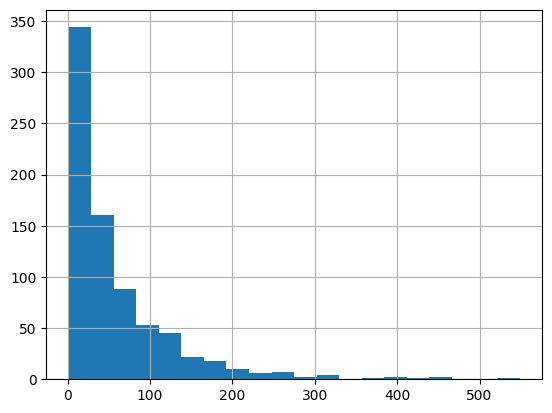

In [23]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~44719.08


<Axes: >

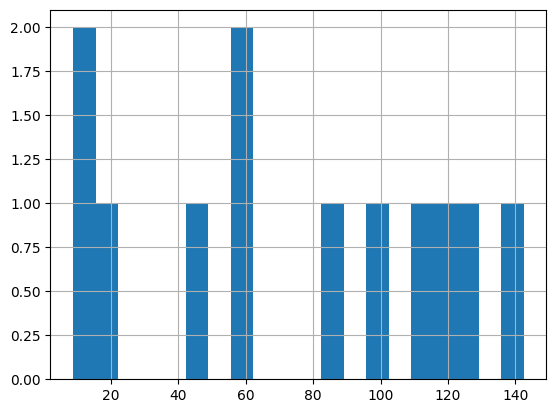

In [40]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure AD Authentication']['age'].hist(bins=20)

# Completely Random Shuffle

In [25]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [26]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [27]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [28]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [29]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [30]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [31]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [32]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [33]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [34]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 767
Total card age: 44719.08


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold,neg_age
144,PowerShell Modules,Install-Module\n\nDefinition: A cmdlet used to...,abd837efe7378e3e46b08d09a459cae3,548.603056,90.966281,-548.603056,2910.920981,0.264215,0,0,-548.603056
145,PowerShell Modules,Ensure scripts use the correct module versions...,2402d2f5a53adb6949774297eeeb0621,187.636844,90.966281,-548.603056,2910.920981,0.264215,3,0,-187.636844
146,PowerShell Modules,Exporting Functions and Cmdlets\nDefinition: T...,bd35c9936ab6714ca8f150b76830fc98,148.508919,90.966281,-548.603056,2910.920981,0.264215,6,0,-148.508919
147,PowerShell Modules,Module Auto-Import\n\nDefinition: See Auto-Imp...,c2156a33b828bfb3ad22d6cd13f617e3,110.422238,90.966281,-548.603056,2910.920981,0.264215,9,0,-110.422238
148,PowerShell Modules,ActiveDirectory Module\n\nDefinition: A module...,089fb36f01ae2d8da1791e9a07f2af99,80.142354,90.966281,-548.603056,2910.920981,0.264215,12,0,-80.142354
149,PowerShell Modules,PSReadLine Module\n\nDefinition: A module that...,b41f499c95e1fc0bd9767a6315e4b432,57.806233,90.966281,-548.603056,2910.920981,0.264215,15,0,-57.806233
150,PowerShell Modules,Connect-AzAccount\n\nDefinition: A cmdlet from...,7faeb939687d0f52394878bd6570d313,37.083842,90.966281,-548.603056,2910.920981,0.264215,18,0,-37.083842
665,PowerShell Modules,Cmdlet\n\nDefinition: A lightweight command us...,692a763236a9d9ad1fb415a847113276,31.082526,90.966281,-548.603056,2910.920981,0.264215,21,0,-31.082526
152,PowerShell Modules,Get-Help\n\nDefinition: A cmdlet that displays...,8f253d8937563b35e910f417121fae9b,25.268548,90.966281,-548.603056,2910.920981,0.264215,24,0,-25.268548
153,PowerShell Modules,Module Load Order\n\nDefinition: The sequence ...,a73a2a72233bd246a7d370085061e59a,15.586483,90.966281,-548.603056,2910.920981,0.264215,27,0,-15.586483


## Card Count

In [35]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [36]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [37]:
if existing_cards.age.sum() < 0:
    asc = True
else: asc = False
existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold,neg_age
144,PowerShell Modules,Install-Module\n\nDefinition: A cmdlet used to...,abd837efe7378e3e46b08d09a459cae3,548.603056,90.966281,-548.603056,2910.920981,0.264215,0,0,-548.603056
66,Azure Compute Gallery,VM Deployment from ACG – The process of creati...,9b589f2fb52eedf61e2dc11f57da0d0f,465.884858,81.490408,-465.884858,3259.616339,0.975535,0,0,-465.884858
186,Azure Functions + PP365,API Gateway Integration\nConnecting Azure Func...,d0210993b8fa777c35753f8d26d9c4a9,454.881113,86.245012,-454.881113,1811.145256,0.126172,0,0,-454.881113
260,Azure Developer Associate,You have an Azure event hub. You need to add p...,e1d05b7e22576ea7494bc54377cf9d46,429.851051,48.620464,-429.851051,3306.191531,0.664718,0,0,-429.851051
193,Azure Private DNS,DNS Proxy\nDefinition: A feature that allows D...,7afb51ca2c17c5d23a40fbb536b4ef56,406.196134,73.748737,-406.196134,1401.225997,0.874431,0,0,-406.196134
155,FSLogix,Q: How does FSLogix Profile Container enhance ...,6e14a79eafeac794c566a2f5be07a49e,401.316121,82.374073,-401.316121,2800.718493,0.851971,0,0,-401.316121
200,Terraform,terraform validate:\nA CLI command that checks...,036e232f01695e400da5847ea8babd0d,371.349908,77.890877,-371.349908,1402.035782,0.497907,0,0,-371.349908
101,Python,Q:\nHow can you obtain command-line arguments ...,6a00d6335b8d45302a333e507237865b,319.745211,49.157854,-319.745211,2949.471217,0.471203,0,0,-319.745211
516,Azure Developer Associate,You plan to generate a shared access signature...,d6a7ed20d7e17dc1c61b36d373e2eb48,314.868131,48.620464,-429.851051,3306.191531,0.664718,1,1,-314.868131
167,C# Basics,What’s the difference between delegates and ev...,aafda82832da4aaff149c8153e06fc0a,314.504617,65.736569,-314.504617,2037.833635,0.337163,0,0,-314.504617


In [38]:
existing_cards['age'].mean()

58.30388467233861